<h1><center>Лабораторна робота 4.</center></h1>
<h2><center>Прогнозування популярності статей на TechMedia (Хабр) за допомогою лінійних моделей</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

<a class="anchor" id="lab-4"></a>

## Зміст

- [4.1. Розбиття на train/valid](#lab-4.1)
- [4.2. Застосування TfidfVectorizer](#lab-4.2)
- [4.3. Робота з категоріальним ознаками](#lab-4.3)
- [4.4. Навчання моделі](#lab-4.4)
- [4.5 Baseline](#lab-4.5)

У цій лабораторній роботі Вам пропонується розібратися з тим, як працює TfidfVectorizer і DictVectorizer, навчити й налаштувати модель лінійної регресії Ridge за набором даних про публікації на Хабрахабр.

**Опис завдання:**

Необхідно зробити прогноз того, як багато зірочок набере стаття, знаючи тільки її текст і час публікації.

Побудуйте прогноз популярності статті на Хабрі за змістом і часом публікації. Як відомо, користувачі Хабра можуть додавати статті собі в профіль у розділ *обране*. Загальна кількість користувачів, що виконала цю дію, відображається у статті кількістю зірочок. Будемо вважати, що кількість зірочок у статтінайкраще відображає її популярність.

Більш формально, за метрику популярності статті будемо використовувати частку статей за останній місяць, у яких кількість зірочок менше ніж має поточна стаття. А точніше, частці числа зірочок можна поставити у відповідність квантилі стандартного розподілу; у такий спосіб отримуємо кількісну характеристику популярності статті. Популярність статті *0* означає, що стаття отримала рівно стільки зірочок, скільки в середньому отримують статті. І відповідно чим більше зірочок отримала стаття в порівнянні із середнім значенням, тим вище це число.

**Розпочнемо:** імпортуємо необхідні бібліотеки і завантажимо дані.

In [1]:
import numpy as np
import pandas as pd
import scipy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

Подібна задача раніше подавалася на змаганнях в Kaggle [version_1](https://www.kaggle.com/c/howpop-habrahabr-favs-lognorm/overview) та [version_2](https://www.kaggle.com/c/howpop-habrahabr-favs).

In [3]:
howpop_train_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-04_popularity-ridge/howpop_train.csv'
howpop_test_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-04_popularity-ridge/howpop_test.csv'

train_df = pd.read_csv(howpop_train_url)
test_df  = pd.read_csv(howpop_test_url)

На прикладі першого об'єкта набору даних переглянемо ознаки всього набору:

In [4]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [5]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Переконаємося, що дані відсортовано за ознакою `published`.

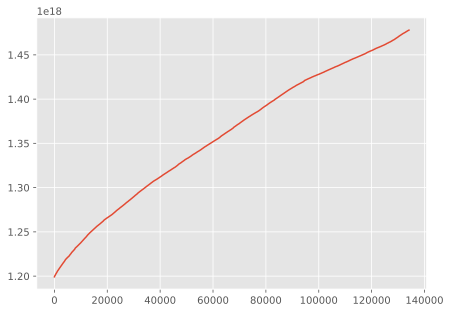

In [6]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

### <span style="color:red; font-size:1.5em;">Завдання 1</span>

Виконайте первинний аналіз навчального набору даних (train_df):

**Для варіантів 1-5:**

Вкажіть дві ознаки, коефіцієнт кореліції між якими є найбільшим (за модулем).

**Для варіантів 6-10:**

В якому році було найменше публікацій?

**Для варіантів 11-15:**

В якому році було найбільше публікацій?

**Для варіантів 16-20:**

Вкажіть дві ознаки, коефіцієнт кореліції між якими є найменшим (за модулем).

In [8]:
train_df.published.apply(lambda ts: pd.to_datetime(ts).year).value_counts().sort_values(ascending=[True])

2008     7743
2009    10783
2010    13091
2011    15063
2013    15537
2012    15972
2014    16180
2016    16316
2015    23452
Name: published, dtype: int64

***Примітка 1:*** Для вирішення завдання 1 використайте [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), [pandas.to_datetime()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) та [pandas.Series.value_counts()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html).

***Примітка 2:*** Зверніть увагу, кореляція ознаки із самою на себе завжди буде 1.

***Примітка 3:*** Рахувати кількість публікацій можна за ознакою *published*.

<a class="anchor" id="lab-4.1"></a>

## <span style="color:blue; font-size:1.2em;">4.1. Розбиття на train/valid</span>

[Повернутися до змісту](#lab-4)

Використовуємо тільки ознаки 'author', 'flow', 'domain' та 'title'.

In [9]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [10]:
len(train_df), train_size

(134137, 93895)

In [11]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] # відокремлюємо ознаки від цільової змінної
X_test = test_df.loc[:, features]

In [12]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]
y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

<a class="anchor" id="lab-4.2"></a>

## <span style="color:blue; font-size:1.2em;">4.2. Застосування TfidfVectorizer</span>

[Повернутися до змісту](#lab-4)

**[TF-IDF](https://uk.wikipedia.org/wiki/TF-IDF)** (з англ. TF – term frequency, IDF – inverse document frequency) – статистична міра, яка використовується для оцінки важливості слова в контексті документа, що є частиною колекції документів або корпусу. Вага деякого слова є пропорційною кількості вживання цього слова в документі, і обернено пропорційною частоті вживання слова в інших документах колекції.

Тут ми будемо використовувати клас [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) з бібліотеки scikit-learn. Об'єкт цього класу перетворює тексти в матрицю TF-IDF ознак.

**Основні параметри TfidfVectorizer в sklearn:**

- **min_df** – у разі побудови словника слова, які зустрічаються *рідше*, ніж вказане значення, ігноруються;
- **max_df** – у разі побудови словника слова, які зустрічаються *частіше*, ніж вказане значення, ігноруються;
- **analyzer** – визначає, чи будуються ознаки за словами або за символами (літерами);
- **ngram_range** – визначає, чи формуються ознаки тільки з окремих слів або з декількох слів (у випадку з analyzer='char' задає кількість символів); наприклад, якщо вказати analyzer='word' і ngram_range=(1,3), то ознаки будуть формуватися з окремих слів, з пар слів і з трійок слів;
- **stop_words** – слова, які ігноруються під час побудови матриці.

Більш детально з параметрами можна ознайомитися в [документації](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

**Ініціалізуйте TfidfVectorizer з параметрами min_df=3, max_df=0.3 та ngram_range=(1,3).**

Застосуйте метод **fit_transform** до `X_train['title']` і метод **transform** до `X_valid['title']` та `X_test['title']`.

In [14]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))

X_train_title = vectorizer_title.fit_transform(X_train['title'])
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])

In [30]:
# Можна подивитися словник у вигляді {'термін': індекс ознаки,...}
vectorizer_title.vocabulary

**Ініціалізуйте TfidfVectorizer з параметром analyzer='char'.**

Застосуйте метод **fit_transform** до `X_train['title']` і метод **transform** до `X_valid['title']` та `X_test['title']`.

In [16]:
vectorizer_title_ch = TfidfVectorizer(analyzer='word')

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])

In [17]:
X_train_title_ch.shape

(93895, 218)

In [ ]:
# Тут так само можна подивитися словник
vectorizer_title_ch.vocabulary_

В результаті використання `TfidfVectorizer` отримали два словника. Зверніть увагу наскільки відрізняються ініціалізовані словники для TfidfVectorizer з `analyzer='word'` та `analyzer='char'`.

### <span style="color:red; font-size:1.5em;">Завдання 2</span>

Дайте відповідь на запитання:

**Для варіантів 1-5:**

Який розмір ініціалізованого словника для TfidfVectorizer з параметрами min_df=3, max_df=0.3 та ngram_range=(1,3)? (тут `analyzer='word'`)

**Для варіантів 6-10:**

Який індекс у слова ***'nvidia'*** для TfidfVectorizer з параметрами min_df=3, max_df=0.3 та ngram_range=(1,3)? (`analyzer='word'`)

**Для варіантів 11-15:**

Який розмір словника для TfidfVectorizer з символьним заданням ознаки?

**Для варіантів 16-20:**

Який індекс у символа ****$**** для TfidfVectorizer з символьним заданням ознаки?

<a class="anchor" id="lab-4.3"></a>

In [18]:
vectorizer_title.vocabulary_['nvidia']

7978

## <span style="color:blue; font-size:1.2em;">4.3. Робота з категоріальним ознаками</span>

[Повернутися до змісту](#lab-4)

Для оброблення категоріальних ознак 'author', 'flow', 'domain' ми будемо використовувати [DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) з sklearn.

In [19]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Розглянемо як DictVectorizer працює за прикладом перших п'яти рядків:

In [20]:
# для початку заповнюємо пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [21]:
# Перетворимо датафрейм в словник, де ключами є індекси об'єктів (саме для цього ми транспонували датафрейм),
# а значеннями є словники у вигляді 'назва_колонки': 'значення'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [22]:
# У DictVectorizer нам потрібно буде передати список словників для кожного об'єкта у вигляді 'назва_колонки': 'значення',
# тому використовуємо .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [23]:
# У підсумку виходить розріджена матриця
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [24]:
# Але можна перетворити її в numpy array за допомогою .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [25]:
# У результуючій матриці є 5 рядків (за числом об'єктів) та 9 стовпців
# Далі розберемося чому колонок саме 9
dict_vect_matrix.shape

(5, 9)

Подивимося скільки унікальних значень є в кожному стовпчику:

In [26]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


Загалом є 9 унікальних значень – стільки ж, скільки і колонок. Це пояснюється тим, що для категорійних ознак з рядковими значеннями DictVectorizer робить кодування бінарними ознаками – кожному унікальному значенню ознаки відповідає одна нова бінарна ознака, яка дорівнює 1 тільки в тому випадку, коли в початковій матриці ця ознака приймає значення, якому відповідає ця колонка нової матриці.

**Ініціалізуйте DictVectorizer з параметрами за замовчуванням.**

Застосуйте метод **fit_transform** до `X_train[feats]` і метод **transform** до `X_valid[feats]` та `X_test[feats]`.

In [27]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train.loc[:, feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid.loc[:, feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test.loc[:, feats].fillna('-').T.to_dict().values())

Об'єднаємо всі отримані матриці за допомогою `scipy.sparse.hstack()`:

In [28]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

### <span style="color:red; font-size:1.5em;">Завдання 3</span>

**Для варіантів 1-5:**

Який розмір отриманого словника для DictVectorizer з параметрами за замовчуванням?

**Для варіантів 6-10:**

Виведіть усі колонки отриманої матриці `dict_vect_matrix` (ознака dict_vect).

**Для варіантів 11-15:**

Виведіть вміст створеного словника DictVectorizer.

**Для варіантів 16-20:**

Перевірте ознаки, за якими будувався словник dict_vect (атрибут `feature_names_`)

<a class="anchor" id="lab-4.4"></a>

In [47]:
X_train_feats.shape

(93895, 17869)

## <span style="color:blue; font-size:1.2em;">4.4. Навчання моделі</span>

[Повернутися до змісту](#lab-4)

Далі будемо використовувати [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), лінійну модель з l2-регуляризацією.

Основний параметр Ridge – **alpha, коефіцієнт регуляризації**. Регуляризація використовується для поліпшення узагальнюючої здатності моделі – додаючи до функціоналу втрат суму квадратів ваг, що помножена на коефіцієнт регуляризації (та сама alpha), ми штрафуємо модель за надто великі значення ваг і не дозволяємо їй перенавчатися. Чим більше значення цього коеефіціенту, тим сильніше ефект.

**Виконайте навчання двох моделей за X_train_new, y_train, задавши в першій alpha=0.1 і random_state=1, а в другій – alpha=1.0 і random_state=1.**

Обрахуйте середньоквадратичну помилку кожної моделі (mean_squared_error, MSE). Порівняйте значення помилки за навчальною та валідаційною вибірками та дайте відповідь на питання.

In [33]:
%%time
model1 = Ridge(alpha=0.1,random_state=1)
model1.fit(X_train_new, y_train)

# Тут також Ваш код

train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('MSE за навчальним набором: ',mean_squared_error(y_train, train_preds1))
print('MSE за валідаційним набором: ',mean_squared_error(y_valid, valid_preds1))

MSE за навчальним набором:  0.18452335504527054
MSE за валідаційним набором:  0.9036980824620631
CPU times: user 7.26 s, sys: 5.72 s, total: 13 s
Wall time: 6.96 s


In [34]:
%%time
model2 = Ridge(alpha=1.0,random_state=1)
model2.fit(X_train_new, y_train)

train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('MSE за навчальним набором: ',mean_squared_error(y_train, train_preds2))
print('MSE за валідаційним набором: ',mean_squared_error(y_valid, valid_preds2))

MSE за навчальним набором:  0.28674076626948974
MSE за валідаційним набором:  0.7010885114715637
CPU times: user 3.39 s, sys: 2.47 s, total: 5.86 s
Wall time: 3.51 s


### <span style="color:red; font-size:1.5em;">Завдання 4</span>

На основі результатів навчання моделі дайте відповідь на запитання нижче:

**Для варіантів 1-5:**

Чи справді обидві моделі показують однаковий результат? (тобто середньоквадратична помилка відрізняється не більше, ніж на тисячні)

**Для варіантів 6-10:**

Чи справді модель починає перенавчається при alpha = 0.1?

**Для варіантів 11-15:**

Середньоквадратична помилка (MSE) якої моделі за тестовим набором даних менше?

**Для варіантів 16-20:**

За якого значення alpha модель краще узагальнює дані: alpha = 0.1 чи alpha = 1.0? Як ми це бачимо?

<a class="anchor" id="lab-4.5"></a>

In [ ]:
#Так

## <span style="color:blue; font-size:1.2em;">4.5. Baseline</span>

[Повернутися до змісту](#lab-4)

Тепер спробуємо отримати так званий бейзлайн (з англ. baseline – базовий рівень) для змагання – використовуйте Ridge з параметрами за замовчуванням і навчіть модель за усіма даними – з'єднайте X_train_new та X_valid_new (використовуйте `scipy.sparse.vstack()`), а цільовою змінною буде y.

In [35]:
%%time
model3 = Ridge()
model = Ridge()

model.fit(scipy.sparse.vstack([X_train_new, X_valid_new]), y) 
test_preds = model.predict(X_test_new)

CPU times: user 5.72 s, sys: 4.15 s, total: 9.86 s
Wall time: 7.39 s


In [36]:
habr_sample_submission_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-04_popularity-ridge/habr_sample_submission.csv'

habr_sample_submission = pd.read_csv(habr_sample_submission_url, 
                                index_col='url')

In [37]:
habr_sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [38]:
ridge_submission = habr_sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds

# це буде бейзлайн "Просте рішення"
ridge_submission.to_csv('habr_ridge_baseline.csv')

### <span style="color:red; font-size:1.5em;">Завдання 5</span>

**Для усіх варіантів:**

Виведіть значення змінної `test_preds` та покажіть вміст файлу `habr_ridge_baseline.csv`

In [41]:
print(test_preds)#5

[ 0.43435335 -1.09260971  0.65548665 ...  0.64503734  0.02541083
  0.60407764]


In [44]:
baseline = 'habr_ridge_baseline.csv'

df = pd.read_csv(baseline)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
favs_lognorm,3990.0,0.149387,0.629606,-2.473313,-0.239494,0.175721,0.575151,2.483398


In [45]:
pd.set_option('display.max_rows', 10)
print(df)

                                                    url  favs_lognorm
0                     https://habrahabr.ru/post/314080/      0.434353
1       https://habrahabr.ru/company/plesk/blog/313732/     -1.092610
2       https://habrahabr.ru/company/etagi/blog/314000/      0.655487
3      https://habrahabr.ru/company/knopka/blog/314030/      0.518344
4     https://geektimes.ru/company/audiomania/blog/2...      1.150439
...                                                 ...           ...
3985                  https://geektimes.ru/post/281642/     -0.014880
3986   https://habrahabr.ru/company/tuturu/blog/320326/      0.267876
3987  https://habrahabr.ru/company/gemaltorussia/blo...      0.645037
3988                  https://habrahabr.ru/post/320472/      0.025411
3989     https://habrahabr.ru/company/croc/blog/320470/      0.604078

[3990 rows x 2 columns]
